In [2]:
library(lisi)
library(Seurat)
library(harmony)
library(magrittr)
library(gridExtra)
library(ggthemes)
library(scales)
library(pheatmap)
library(dplyr)
library(monocle)
library(reticulate)
library(ggbeeswarm)
library(ggrepel)
library(plyr)
library(ggplot2)
library(gridExtra)
library(ggthemes)
library(scales)
library(pheatmap)
library(dplyr)
library(RColorBrewer)
library(ggbeeswarm)
library(ggrepel)
library(patchwork)
library(MASS)
library(matrixStats)
library(viridis)
library(pbapply)
library(parallel)
library(grid)

# LISI: (Local inverse Simpson’s index): measures degree of batch mixing in a low-dimensional embedding
#### "Instead of a fixed number of nearest neighbors as in the case of kBET, LISI selects the nearest neighbors based on the local distribution of distances with a fixed perplexity"
#### "The selected neighbors are then used to compute the inverse Simpson’s index for diversity, which is the effective number of types present in this neighborhood"

## After harmony correction

In [6]:
meta_all <- readRDS("meta_all_COVID19_RA_Rahul_SLE_UC_Crohn_MS_lung_pca_umap_harmony_umap_cluster_new_new_new_2020-05-26.rds")
meta_all$cell <- as.character(meta_all$cell)
rownames(meta_all) <- meta_all$cell  
meta_all[1:4, c("sample", "broad_cell_type_nk_dc", "tissue", "technology")]

sample,broad_cell_type_nk_dc,tissue,technology
301-0159,T cells,Synovium,CEL-Seq2
301-0159,T cells,Synovium,CEL-Seq2
301-0159,T cells,Synovium,CEL-Seq2
301-0159,T cells,Synovium,CEL-Seq2


In [23]:
length(table(meta_all$sample))
table(meta_all$tissue)

[1] 158


    BALF    Brain    Colon    Ileum   Kidney     Lung Synovium 
   65918     1086   140069    46576     2678    41563    11658 

In [11]:
# res <- compute_lisi(x, x_meta_all, c("sample", "site"), perplexity=30, nn_eps=0)
# res <- compute_lisi(x, x_meta_all, c("dataset", "sample", "cell_type", "disease", "res_0.30"), perplexity=30, nn_eps=0)

lisi_res <- rbind(
    lisi::compute_lisi(meta_all[,c(31:40)], meta_all, c("sample", "broad_cell_type_nk_dc", "tissue", "technology"))
) %>% 
    tidyr::gather(key, val, sample, broad_cell_type_nk_dc, tissue, technology)

lisi_res[1:4,]

saveRDS(lisi_res, "LISI_after_harmony_2020-05-30.rds")

key,val
sample,10.326378
sample,6.698756
sample,8.725586
sample,8.660591


In [3]:
lisi_res <- readRDS("LISI_after_harmony_2020-05-30.rds")
lisi_res[1:4,]

lisi_res %>% 
    group_by(key) %>%
    summarise_all("mean")

key,val
sample,10.326378
sample,6.698756
sample,8.725586
sample,8.660591


key,val
broad_cell_type_nk_dc,1.044859
sample,6.118483
technology,1.132916
tissue,1.834497


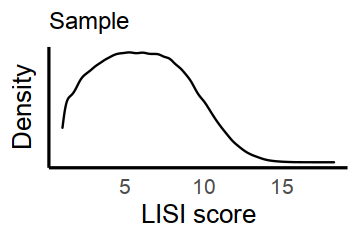

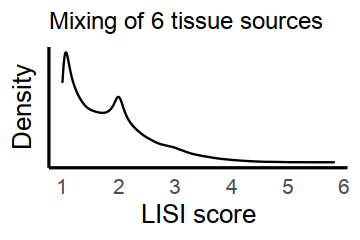

In [10]:
options(repr.plot.height = 2, repr.plot.width = 3)

ggplot(lisi_res[which(lisi_res$key == "sample"),]) +
    geom_density(
        aes(x  = val)
    ) +
#   scale_x_continuous(limits = c(1, 15))+
  labs(
      x = "LISI score",
      y = "Density",
#       title = paste0("Mixing of ", length(table(meta_all$sample))," samples", sep="")
      title = "Sample"
      ) +
  theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
    axis.text.y = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=14)
  )
ggsave("LISI_after_harmony_sample.pdf", width = 3, height = 2)


ggplot(lisi_res[which(lisi_res$key == "tissue"),]) +
    geom_density(
        aes(x  = val)
    ) +
#   scale_x_continuous(limits = c(1, 5))+
  labs(
      x = "LISI score",
      y = "Density",
      title = paste0("Mixing of 6 tissue sources", sep="")
      ) +
  theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
    axis.text.y = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=14)
  )
ggsave("LISI_after_harmony_tissue.pdf", width = 3, height = 2)



## Load the before harmonization embeddings

In [25]:
meta_all[1:4, c(11:20)]

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0.06428479,0.2089305,0.10230234,-0.1570187,-0.04675223,-0.02924620,-0.069733034,0.10760739,0.03805453,-0.03150895
0.10655340,0.2316091,0.12669262,-0.1642951,-0.00562886,-0.05401619,-0.089115737,0.07985903,0.06891159,-0.02968829
0.08089054,0.2033624,0.08698473,-0.1564867,-0.05886262,-0.04161044,-0.002807086,0.08879164,0.05359425,-0.07058511
0.07549270,0.2632283,0.12058181,-0.1687226,-0.05056625,-0.01973639,-0.092938785,0.11486237,0.05590524,-0.01765274


In [26]:
lisi_res <- rbind(
    lisi::compute_lisi(meta_all[,c(11:20)], meta_all, c("sample", "broad_cell_type_nk_dc", "tissue", "technology"))
) %>% 
    tidyr::gather(key, val, sample, broad_cell_type_nk_dc, tissue, technology)

lisi_res[1:4,]

saveRDS(lisi_res, "LISI_before_harmony_2020-05-30.rds")

key,val
sample,3.274203
sample,3.957039
sample,7.270507
sample,7.144615


In [11]:
lisi_res <- readRDS("LISI_before_harmony_2020-05-30.rds")
lisi_res[1:4,]

lisi_res %>% 
    group_by(key) %>%
    summarise_all("mean")

key,val
sample,3.274203
sample,3.957039
sample,7.270507
sample,7.144615


key,val
broad_cell_type_nk_dc,1.087411
sample,2.894040
technology,1.004376
tissue,1.091131


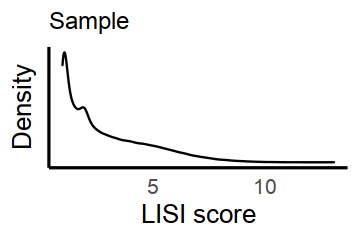

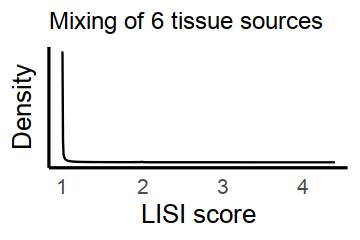

In [16]:
options(repr.plot.height = 2, repr.plot.width = 3)

ggplot(lisi_res[which(lisi_res$key == "sample"),]) +
    geom_density(
        aes(x  = val)
    ) +
#   scale_x_continuous(limits = c(1, 15))+
  labs(
      x = "LISI score",
      y = "Density",
      title = "Sample"
      ) +
  theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
    axis.text.y = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=14)
  )
ggsave("LISI_before_harmony_sample.pdf", width = 3, height = 2)


ggplot(lisi_res[which(lisi_res$key == "tissue"),]) +
    geom_density(
        aes(x  = val)
    ) +
#   scale_x_continuous(limits = c(1, 5))+
  labs(
      x = "LISI score",
      y = "Density",
      title = paste0("Mixing of 6 tissue sources", sep="")
      ) +
  theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
    axis.text.y = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=14)
  )
ggsave("LISI_before_harmony_tissue.pdf", width = 3, height = 2)
